# Linear Gaussian State Space Model

In [184]:
from jax import numpy as jnp
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt

from dynamax.utils.plotting import plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter

import numpy as np
from scipy import stats

## Agenda

1. Introduce Linear Gaussian SSMS
   * Key difference between our discrete
2. Talk through Kalman Filter book
3. Reimplement Dog Example in Dynamax
4. Talk through State Space Linear Regression

## Kalman and Bayesian Filters in Python


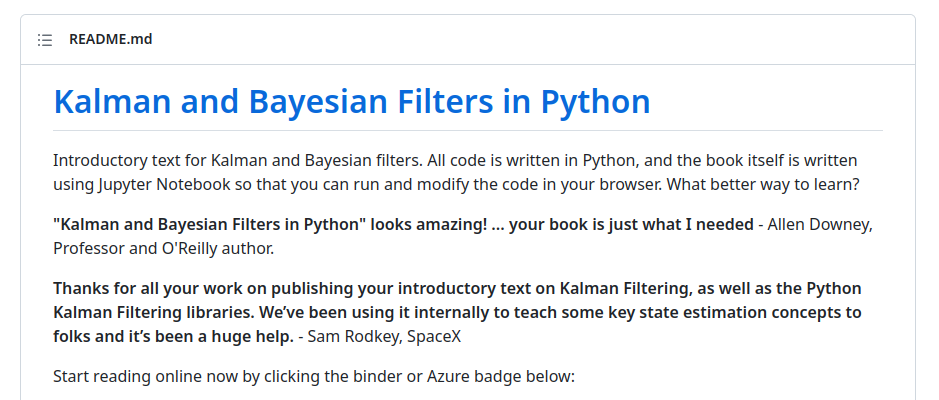
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

## Look familiar?

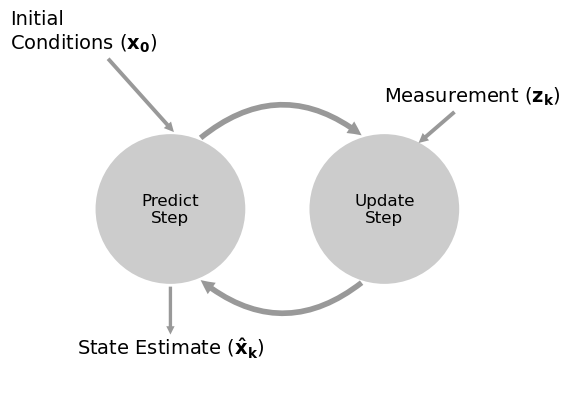

## Visual Example

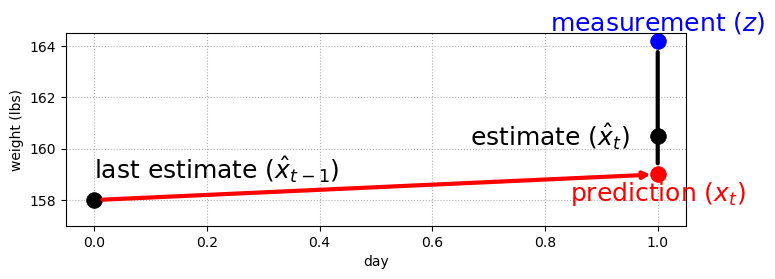

## Bayesian Filters in Python Dog Example
One dimensional example from Chapter 4
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/04-One-Dimensional-Kalman-Filters.ipynb

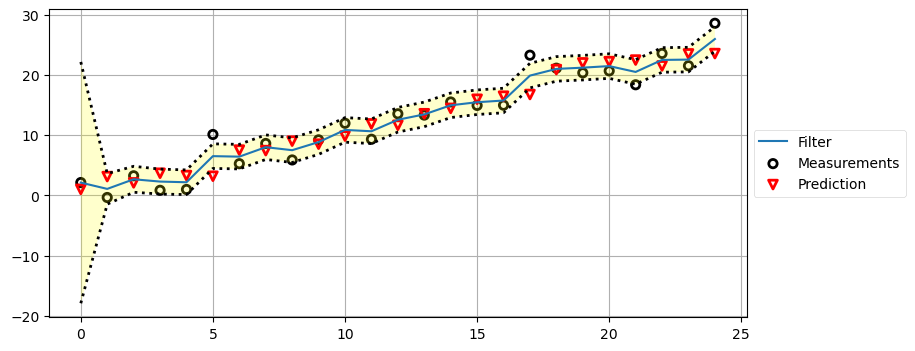

## Code from book

In [18]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])

### Constants

In [1]:
dt = 1. # time step in seconds\
velocity = 1

### Observations
Two sources of variation
1. Where the dog moves to
2. What the sensor reports

In [185]:
dog_moves = [
  1.3535959735108178,
  1.8820653967131618,
  4.341047429453569,
  7.156332673205118,
  6.938695089418526,
  6.843912342028484,
  9.846824080052299,
  12.553482049375292,
  16.2730841073834,
  14.800411177015299]

## Analytical Solution

In [40]:
pos = gaussian(0., 20.**2)

for z in dog_moves: #for z in zs:
    print(pos)
    dx = velocity*dt
    
    # pos = pos + dx
    pos_mean = pos.mean + dx
    pos_var = pos.var + process_var

    # Likelihood update
    # Weighted calculation of position 
    pos_updated  = (pos_var*z + sensor_var*pos_mean) / (pos_var + sensor_var)
    
    # Weighted calculation of variance
    var_updated = (pos_var * sensor_var) / (pos_var + sensor_var)
    pos = gaussian(pos_updated, var_updated)
    
print(pos)

Gaussian(mean=0.0, var=400.0)
Gaussian(mean=1.351841154783717, var=1.9900744416873448)
Gaussian(mean=2.070349464840893, var=1.198408751864744)
Gaussian(mean=3.7357238224806713, var=1.0472580836195666)
Gaussian(mean=5.960160449584709, var=1.0116765678499313)
Gaussian(mean=6.949396530475968, var=1.0029106453754295)
Gaussian(mean=7.396252519656308, var=1.000727132237836)
Gaussian(mean=9.121670120559637, var=1.0001817500203842)
Gaussian(mean=11.337631330190714, var=1.000045435440623)
Gaussian(mean=14.30538006966205, var=1.0000113587311334)
Gaussian(mean=15.052894906364974, var=1.0000028396747196)


## Dynamax and dog example

### Different Dynamics Model Representations

\begin{align*}
\underbrace{\begin{pmatrix} u_t\\ v_{t} \end{pmatrix}}_{z_t}
  = 
\underbrace{
\begin{pmatrix}
1 & \Delta  \\
0 & 1  \\
\end{pmatrix}
}_{F}
\underbrace{\begin{pmatrix} u_{t-1} \\ v_{t-1} \end{pmatrix}}_{z_{t-1}}
+ q_t
\end{align*}

\begin{align*}
\underbrace{\begin{pmatrix} u_t\\  \end{pmatrix}}_{z_t}
  = 
\underbrace{
\begin{pmatrix}
1 & \Delta  \\
\end{pmatrix}
}_{F}
\underbrace{\begin{pmatrix} u_{t-1} \\ v \end{pmatrix}}_{z_{t-1}}
+ q_t
\end{align*}

In [194]:
from jax import random as jr
from dynamax.linear_gaussian_ssm import LinearGaussianSSM
import jax.numpy as jnp


state_dim = 2
emission_dim = 1
delta = 1

# Create object
lgssm = LinearGaussianSSM(state_dim, emission_dim)

# What is emissions covariance
params, _ = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=jnp.array([5., 1]),
                             initial_covariance=jnp.array([[400., 0],
                                                           [0, .0001]]),
                             
                             # How the dog moves
                             dynamics_weights=jnp.array([[1., delta],
                                                        [0, 1]]),
                             
                             # we have very llttle randomness in the dog motion
                             dynamics_covariance=jnp.eye(2) * .00001,

                             # This one must be 2d
                             # Only captures position not velocity
                             emission_weights=jnp.atleast_2d(jnp.array([1., 0])),

                             # Sensor variance
                             emission_covariance=jnp.eye(emission_dim) * 1.0)

# What is emissions covariance
params

ParamsLGSSM(initial=ParamsLGSSMInitial(mean=Array([5., 1.], dtype=float32), cov=Array([[4.e+02, 0.e+00],
       [0.e+00, 1.e-04]], dtype=float32)), dynamics=ParamsLGSSMDynamics(weights=Array([[1., 1.],
       [0., 1.]], dtype=float32), bias=Array([0., 0.], dtype=float32), input_weights=Array([], dtype=float32), cov=Array([[1.e-05, 0.e+00],
       [0.e+00, 1.e-05]], dtype=float32)), emissions=ParamsLGSSMEmissions(weights=Array([[1., 0.]], dtype=float32), bias=Array([0.], dtype=float32), input_weights=Array([], dtype=float32), cov=Array([[1.]], dtype=float32)))

### Prior Sampling

In [192]:
key = jr.PRNGKey(0)
hidden_state, sampled_observations = lgssm.sample(params, key, 10)
print(hidden_state)
print(sampled_observations)

[[ 3.101236    0.9990914 ]
 [ 4.1004004   0.9958241 ]
 [ 5.095522    0.9901454 ]
 [ 6.0851226   0.98828197]
 [ 7.068449    0.9844679 ]
 [ 8.054393    0.9852507 ]
 [ 9.045076    0.9851691 ]
 [10.032094    0.9840263 ]
 [11.017527    0.9831087 ]
 [12.006382    0.98479354]]
[[ 3.679385 ]
 [ 5.4920225]
 [ 4.6654873]
 [ 5.416491 ]
 [ 7.952854 ]
 [ 8.431994 ]
 [ 8.052618 ]
 [11.7541685]
 [10.083383 ]
 [10.730123 ]]


### Posterior Estimation

In [ ]:
lgssm_posterior = lgssm.filter(params, jnp.array(dog_moves))
print(lgssm_posterior.filtered_means)

[[ 1.3626891  1.       ]
 [ 2.1226652  0.9999759]
 [ 3.5285711  1.000106 ]
 [ 5.185849   1.0005527]
 [ 6.3371387  1.0007331]
 [ 7.2552023  1.000577 ]
 [ 8.484806   1.0012115]
 [ 9.874273   1.0027076]
 [11.488147   1.0058514]
 [12.731165   1.0074271]]


### Dynamax learnings
1. [Documentation can be wrong](https://github.com/probml/dynamax/issues/308)
2. Dynamax is real picky about shapes
   * Try modifying any of the shapes and see what happens

## Linear Regression as a State Space Model

https://probml.github.io/dynamax/notebooks/linear_gaussian_ssm/kf_linreg.html

### Takeaways
* There's a lot of letters in SSM
  * https://probml.github.io/dynamax/api.html#linear-gaussian-ssm
* Linear Regression in SSM are a good trick
  * Great way to understand more deeply how to configure SSMS